In [1]:
from requests import get
url = 'https://www.imdb.com/search/title/?release_date=2018-01-01,&sort=num_votes,desc'
response = get(url)
print(response.text[:500])




<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///?src=mdot">



        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle"


In [14]:
from bs4 import BeautifulSoup

# creating the soup object
soup = BeautifulSoup(response.text, 'html.parser')
type(soup)

bs4.BeautifulSoup

Each container contains info about a single movie and the HTML content of one container is very long. So, we will inspect each object that we intend to inspect.

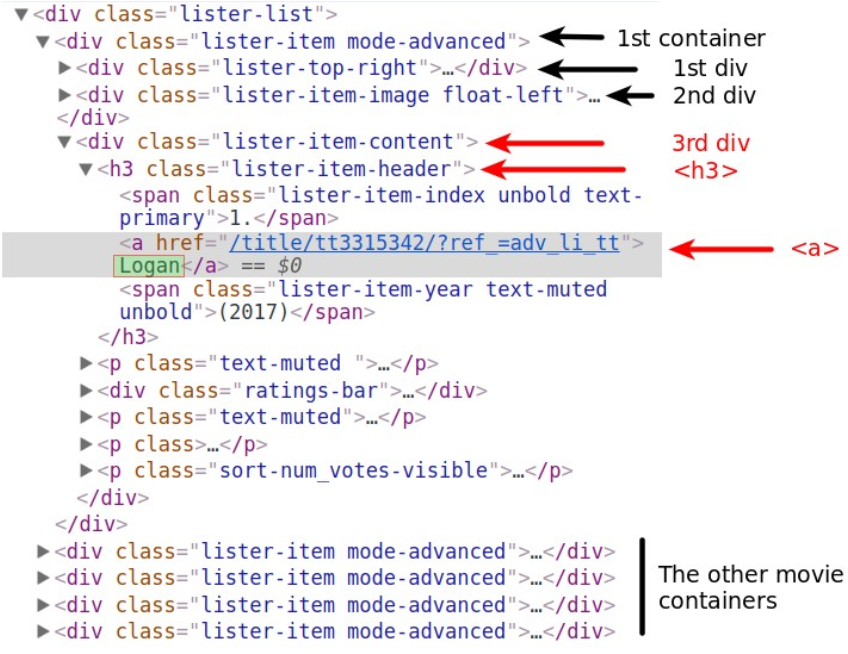

In [15]:
# extracting all the 'div' containers of class attribute "lister-item mode-advanced"
movie_containers = soup.find_all('div', class_ = 'lister-item mode-advanced')
print(type(movie_containers))

# No. of containers in the web page
print(len(movie_containers))

<class 'bs4.element.ResultSet'>
50


Now we’ll select only the first container, and extract, by turn, each item of interest:

1. The name of the movie.
2. The year of release.
3. The IMDB rating.
4. The Metascore.
5. The number of votes.
6. Gross collection

In [25]:
# assiging the firt movie details from the first movie into "first_movie"
first_movie = movie_containers[0]
# getting the first div tag
first_movie.div

<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt7286456"></div>
</div>

In [26]:
# accessing the first anchor tag (<a>) doesn’t take us to the movie’s name. The first <a> is somewhere within the second div:
first_movie.a

<a href="/title/tt7286456/"> <img alt="Joker" class="loadlate" data-tconst="tt7286456" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BNGVjNWI4ZGUtNzE0MS00YTJmLWE0ZDctN2ZiYTk2YmI3NTYyXkEyXkFqcGdeQXVyMTkxNjUyNQ@@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/G/01/imdb/images/nopicture/large/film-184890147._CB466725069_.png" width="67"/>
</a>

In [27]:
#However, accessing the first <h3> tag brings us very close to the first movie name:
first_movie.h3

<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt7286456/">Joker</a>
<span class="lister-item-year text-muted unbold">(2019)</span>
</h3>

In [28]:
#From here, we can use attribute notation to access the first <a> inside the <h3> tag:
first_movie.h3.a

<a href="/title/tt7286456/">Joker</a>

In [50]:
# getting the name by getting the text from the above output
first_movie.h3.a.text

'Joker'

In [48]:
# releasing year of the first first
first_year = first_movie.find('span',
                                 {'class':'lister-item-year text-muted unbold'}).text
first_year

'(2019)'

In [45]:
# first movie rating
first_rating = float(first_movie.strong.text)
first_rating

8.5

In [61]:
# first movie metascore
# while giving the class "metascore  mixed" as arguments, we've to remove one
# white space beteen the words, else find() won't find anything
first_mscore = first_movie.find('span', {'class' : 'metascore mixed'})
first_mscore = int(first_mscore.text)
first_mscore

59

In [79]:
# first movie number of votes
first_votes = first_movie.find('span', attrs = {'name':'nv'})
first_votes= int(first_votes['data-value'])
first_votes

798725

In [136]:
# first movie gross collection in dollar
first_collection = first_movie.find('p', {'class':'sort-num_votes-visible'})
first_collection.text

'\nVotes:\n798,725\n| Gross:\n$335.45M\n'

### Extracting the collection amount from the above output.
#### Method 1
"\d+.\d+" will search for numbers with decimal point in it.
Using [1] to find the second number because the above output will have two numbers i.e. the No. of Votes and the collected amount

In [137]:
import re

In [138]:
first_collection = re.findall('\d+.\d+', first_collection.text)[1]
first_collection = float(first_collection)
first_collection 

335.45

### Till this point, we have completed the script for scraping a single page

If any movie doen't have metascore then it will show error. SO, we are writing the following code to get rid of that:

In [165]:
# Lists to store the scraped data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []
collections = []
# Extract data from individual movie container
for container in movie_containers:
# If the movie has Metascore, then extract:
    if container.find('div', class_ = 'ratings-metascore') is not None:
# The name
        name = container.h3.a.text
        names.append(name)
# The year
        year = container.h3.find('span', class_ = 'lister-item-year').text
        years.append(year)
# The IMDB rating
        imdb = float(container.strong.text)
        imdb_ratings.append(imdb)
# The Metascore
        m_score = container.find('span', class_ = 'metascore').text
        metascores.append(int(m_score))
# The number of votes
        vote = container.find('span', attrs = {'name':'nv'})['data-value']
        votes.append(int(vote))
# The amount of collection
        collection = container.find('p', {'class':'sort-num_votes-visible'})
        collection = re.findall('\d+.\d+', collection.text)[-1]
        collections.append(collection)

In [166]:
#checking the collected data
import pandas as pd
test_df = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes, 'collections': collections
})
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        45 non-null     object 
 1   year         45 non-null     object 
 2   imdb         45 non-null     float64
 3   metascore    45 non-null     int64  
 4   votes        45 non-null     int64  
 5   collections  45 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ KB
None


,movie,year,imdb,metascore,votes,collections
0,Joker,(2019),8.5,59,798725,335.45
1,Avengers: Infinity War,(2018),8.5,68,777175,678.82
2,Avengers: Endgame,(2019),8.4,78,722794,858.37
3,Black Panther,(2018),7.3,88,582766,700.06
4,Once Upon a Time... in Hollywood,(2019),7.7,83,472022,142.50
5,Deadpool 2,(2018),7.7,66,451691,324.59
6,Bohemian Rhapsody,(2018),8.0,49,424601,216.43
7,Gisaengchung,(2019),8.6,96,416448,53.37
8,Captain Marvel,(2019),6.9,64,413128,426.83
9,A Quiet Place,(2018),7.5,82,381785,188.02


# Scraping for multiple pages

We'll create our one-page script doing the three things:
    1. Making all the requests we want from within the loop.
    2. Controlling the loop’s rate to avoid bombarding the server with requests.
    3. Monitoring the loop while it runs.
    
We’ll scrape the first 4 pages of each year in the interval 2000-2019. 4 pages for each of the 18 years makes for a total of 80 pages. Each page has 50 movies, so we’ll scrape data for 4000 movies at most. But not all the movies have a Metascore, so the number will be lower than that. Even so, we are still very likely to get data for over 3000 movies

We’ll control the loop’s rate by using the sleep() function from Python’s time module. sleep() will pause the execution of the loop for a specified amount of seconds.

To mimic human behavior, we’ll vary the amount of waiting time between requests by using the randint() function from the Python’s random module. randint() randomly generates integers within a specified interval.

In [167]:
from time import sleep
from random import randint

In [168]:
# for the modification of "https://www.imdb.com/search/title/?release_date=2017&sort=num_votes,desc&page=1"
pages = [str(i) for i in range(1,5)]
years_url = [str(i) for i in range(2000, 2020)]

Given that we’re scraping 72 pages, it would be nice if we could find a way to monitor the scraping process as it’s still going. It can be very helpful in the testing and debugging process. 

Also, the greater the number of pages, the more helpful the monitoring becomes. If you are going to scrape hundreds or thousands of web pages in a single code run, I would say that this feature becomes a must.

The process for this:
1. Set a starting time using the time() function from the time module, and assign the value to start_time.
2. Assign 0 to the variable requests which we’ll use to count the number of requests.
3. Start a loop, and then with each iteration:
4. Simulate a request.
5. Increment the number of requests by 1.
6. Pause the loop for a time interval between 8 and 15 seconds.
7. Calculate the elapsed time since the first request, and assign the value to elapsed_time.
8. Print the number of requests and the frequency.

In [176]:
from IPython.core.display import clear_output
from time import time
start_time = time()
requests = 0
for _ in range(5):
# A request would go here
    requests += 1
    sleep(randint(1,3))
    current_time = time()
    elapsed_time = current_time - start_time
    print('Request: {}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
clear_output(wait = True)

Request: 1; Frequency: 0.3332595458750083 requests/s
Request: 2; Frequency: 0.3999123955943413 requests/s
Request: 3; Frequency: 0.3749429782027671 requests/s
Request: 4; Frequency: 0.36351987142348297 requests/s
Request: 5; Frequency: 0.38450533444607504 requests/s


In [178]:
from warnings import warn
warn("Warning Simulation")

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Warning Simulation
  


## Piecing everything together

In [185]:
# Lists to store the scraped data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []
collections = []

# Preparing the monitoring of the loop
start_time = time()
requests = 0

# For every year in the interval 2000-2017
for year_url in years_url:

    # For every page in the interval 1-4
    for page in pages:

        # Make a get request
        response = get('http://www.imdb.com/search/title?release_date=' + year_url +
        '&sort=num_votes,desc&page=' + page)

        # Pause the loop
        sleep(randint(8,15))

        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)
        
        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if requests > 72:
            warn('Number of requests was greater than expected.')
            break

        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')

        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
        
        # Extract data from individual movie container
        for container in movie_containers:
        # If the movie has Metascore, then extract:
            if container.find('div', class_ = 'ratings-metascore') is not None:
        # The name
                name = container.h3.a.text
                names.append(name)
        # The year
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)
        # The IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)
        # The Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))
        # The number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))
        # The amount of collection
                collection = container.find('p', {'class':'sort-num_votes-visible'})
                collection = re.findall('\d+.\d+', collection.text)[-1]
                collections.append(collection)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Number of requests was greater than expected.


Request:74; Frequency: 0.0623328104867548 requests/s


In [186]:
# string the extracted data in to a pandas dataframe
movie_ratings = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes, 'collections': collections
})
print(movie_ratings.info())
movie_ratings.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        3240 non-null   object 
 1   year         3240 non-null   object 
 2   imdb         3240 non-null   float64
 3   metascore    3240 non-null   int64  
 4   votes        3240 non-null   int64  
 5   collections  3240 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 152.0+ KB
None


,movie,year,imdb,metascore,votes,collections
0,Joker,(2019),8.5,59,798725,335.45
1,Avengers: Infinity War,(2018),8.5,68,777175,678.82
2,Avengers: Endgame,(2019),8.4,78,722794,858.37
3,Black Panther,(2018),7.3,88,582766,700.06
4,Once Upon a Time... in Hollywood,(2019),7.7,83,472022,142.50
5,Deadpool 2,(2018),7.7,66,451691,324.59
6,Bohemian Rhapsody,(2018),8.0,49,424601,216.43
7,Gisaengchung,(2019),8.6,96,416448,53.37
8,Captain Marvel,(2019),6.9,64,413128,426.83
9,A Quiet Place,(2018),7.5,82,381785,188.02


In [187]:
# storing the data into a CSV file
movie_ratings.to_csv("extracted_movie_ratings.csv")